In [1]:
import cv2
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import ndimage

from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, f1_score
sys.path.append('../src/inference')
from utils import *

import tensorflow as tf

data_dir = '../data/img'
model_dir = '../model'
img_size_grid = (512,512)
img_size_digit = (28,28)

In [2]:
def sort_points(pts):
    pts_sort = pts[np.argsort(pts[:,1])]
    pts_sort = np.array([pts_sort[np.argmin(pts_sort[:2,0])],
                         pts_sort[np.argmax(pts_sort[:2,0])],
                         pts_sort[np.argmax(pts_sort[2:,0])+2],
                         pts_sort[np.argmin(pts_sort[2:,0])+2]])

    ratio = (pts_sort[2,0] - pts_sort[3,0]) / (pts_sort[1,0] - pts_sort[0,0])

    return pts_sort, ratio

def warp_grid(img, pts):
    
    pts_src, ratio = sort_points(np.array(pts))
    
    print(ratio)
    
    pts_dst = np.array([[100,100],[400,100],[400,400],[100,400]])
    h, status = cv2.findHomography(pts_src, pts_dst)
    height, width = img.shape[:2]
    dst = cv2.warpPerspective(img.astype(np.uint8), h, (width,height))
    
    offset = 10
    x0,x1 = np.min(pts_dst[:,0]) - offset, np.max(pts_dst[:,0]) + offset
    y0,y1 = np.min(pts_dst[:,1]) - offset, np.max(pts_dst[:,1]) + offset
    return dst, (x0,x1,y0,y1)

def find_corners_harris(img_in, mask):
    cnt, hierarchy = cv2.findContours(np.expand_dims(mask.copy(), axis=-1).astype(np.uint8),
                                      cv2.RETR_TREE,
                                      cv2.CHAIN_APPROX_NONE)
    
    gray = cv2.dilate(mask.astype(np.uint8), (5,5), iterations = 1).astype(np.float32)
    dst = cv2.cornerHarris(gray, 20, 3, 0.04)
    ret, dst = cv2.threshold(dst, 0.1*dst.max(), 255, 0)
    ret, labels, stats, centroids = cv2.connectedComponentsWithStats(np.uint8(dst))
    
    approx = cv2.approxPolyDP(centroids.astype(int)[1:], 0.1*cv2.arcLength(cnt[0],True), True)
    centroids = sorted(list(np.squeeze(approx)), key=lambda x:[x[0],x[1]])
    
    corner = cv2.drawContours(img_in.copy(), cnt, -1, (0, 255, 0), 3)
    for i in centroids:
        corner = cv2.circle(corner, (i[0], i[1]), 3, (255,0,0), 3)
        corner = cv2.circle(corner, (i[0], i[1]), 3, (255,0,0), 3)
    
    warp, (x0,x1,y0,y1) = warp_grid(img_in.copy(), centroids)

    return corner, warp, warp[y0:y1,x0:x1]

def pad_resize_img(img, img_size):
    h,w,_ = img.shape
        
    if h>w:
        offset = h-w
        left, right = np.floor(offset/2).astype(int), np.ceil(offset/2).astype(int)
        img = cv2.copyMakeBorder(img, 0, 0, left, right, cv2.BORDER_CONSTANT, (0,0,0))
    elif h<w:
        offset = w-h
        top, bot = np.floor(offset/2).astype(int), np.ceil(offset/2).astype(int)
        img = cv2.copyMakeBorder(img, top, bot, 0, 0, cv2.BORDER_CONSTANT, (0,0,0))
        
    img = cv2.resize(img, img_size)
    return img.astype(int)

In [3]:
def load_model(path):
    interpreter = tf.lite.Interpreter(model_path=path)
    interpreter.allocate_tensors()
    return interpreter
    
def inference_grid(interpreter, img):
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Test model on random input data.
    input_shape = input_details[0]['shape']
    input_data = np.array(np.expand_dims(img,axis=0), dtype=np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    
    return np.squeeze(np.rint(output_data))

def inference_digit(interpreter, img):
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Test model on random input data.
    input_shape = input_details[0]['shape']
    input_data = np.array(np.expand_dims(img.reshape(28,28,1), axis=0), dtype=np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    idx = np.argmax(output_data, axis=-1)[0]
    return  idx + 1, output_data[0][idx]

def process_output(p):
    label, _ = ndimage.label(p, np.ones((3,3)))
    m = Counter(label.flatten()).most_common(2)[1][0]
    p = np.where(label==m, 1, 0)
    return p

# TFLite models

In [4]:
digit = load_model(os.path.join(model_dir, 'digit_classifier.tflite'))
grid = load_model(os.path.join(model_dir, 'grid_detection.tflite'))

# Load data

In [5]:
list_path = []
accepted = ['.png', '.jpeg', '.jpg']

for root, dirs, files in os.walk(data_dir):
    for file in files:
        if os.path.splitext(file)[1].lower() in accepted:
            list_path.append(os.path.join(root, file))

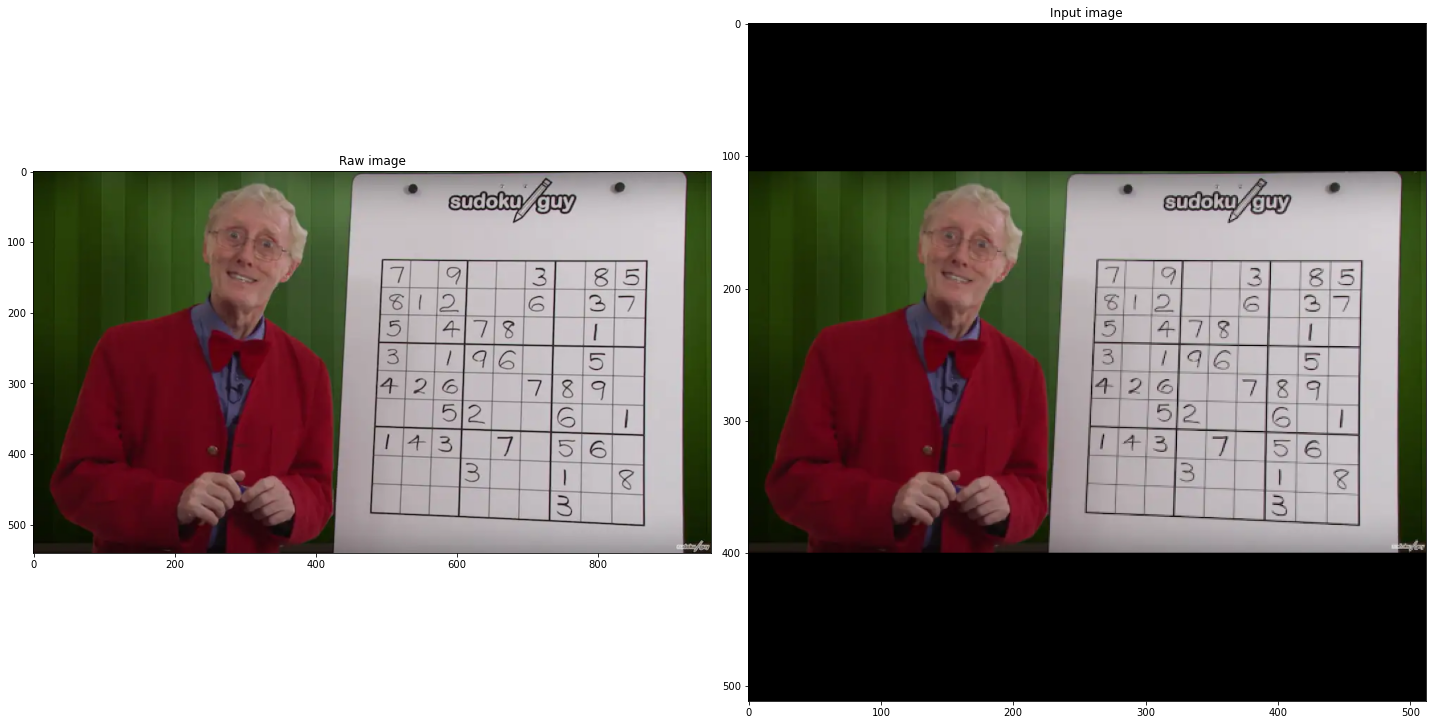

In [6]:
idx = 4
img = cv2.imread(list_path[idx])[:,:,[2,1,0]]
img_in = pad_resize_img(img, img_size_grid)

fig = plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Raw image')
plt.subplot(1,2,2)
plt.imshow(img_in)
plt.title('Input image')

plt.tight_layout()
plt.show()

# Inference

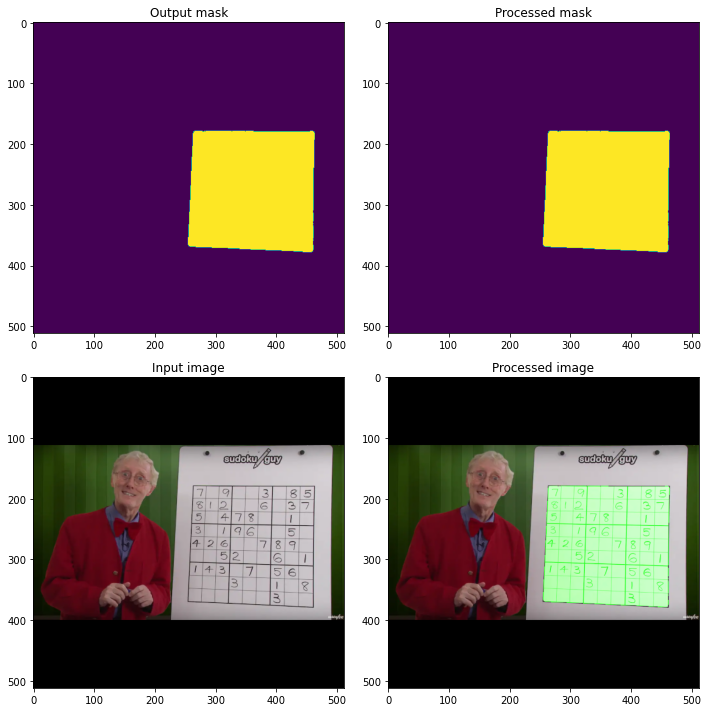

In [7]:
pred = inference_grid(grid, img_in)
mask = process_output(pred)

fig = plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(pred)
plt.title('Output mask')
plt.subplot(2,2,2)
plt.imshow(mask)
plt.title('Processed mask')
plt.subplot(2,2,3)
plt.imshow(img_in)
plt.title('Input image')
plt.subplot(2,2,4)
green = np.zeros(img_in.shape)
green[mask.astype(bool)] = [0,255,0]
res = cv2.bitwise_or(img_in.astype(np.uint8), green.astype(np.uint8))
plt.imshow(res)
plt.title('Processed image')

plt.tight_layout()
plt.show()

1.0360824742268042


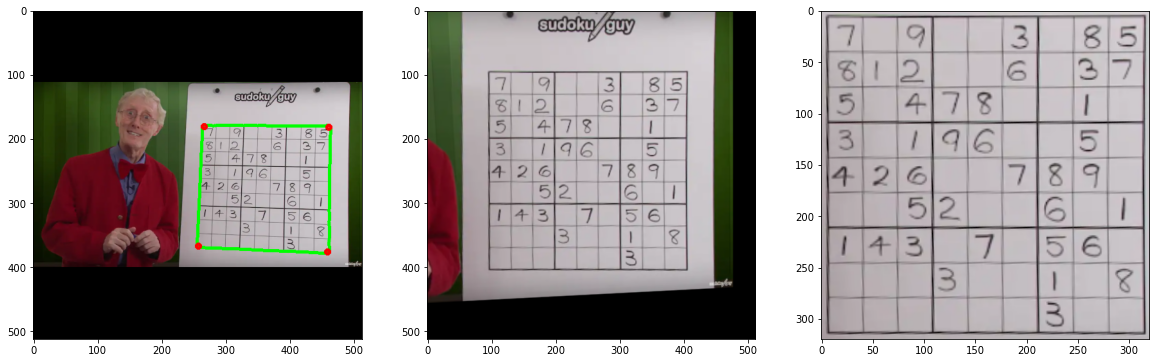

In [8]:
corner, warp, warp_box = find_corners_harris(img_in, mask)

fig = plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(corner)
plt.subplot(1,3,2)
plt.imshow(warp)
plt.subplot(1,3,3)
plt.imshow(warp_box)

plt.show()

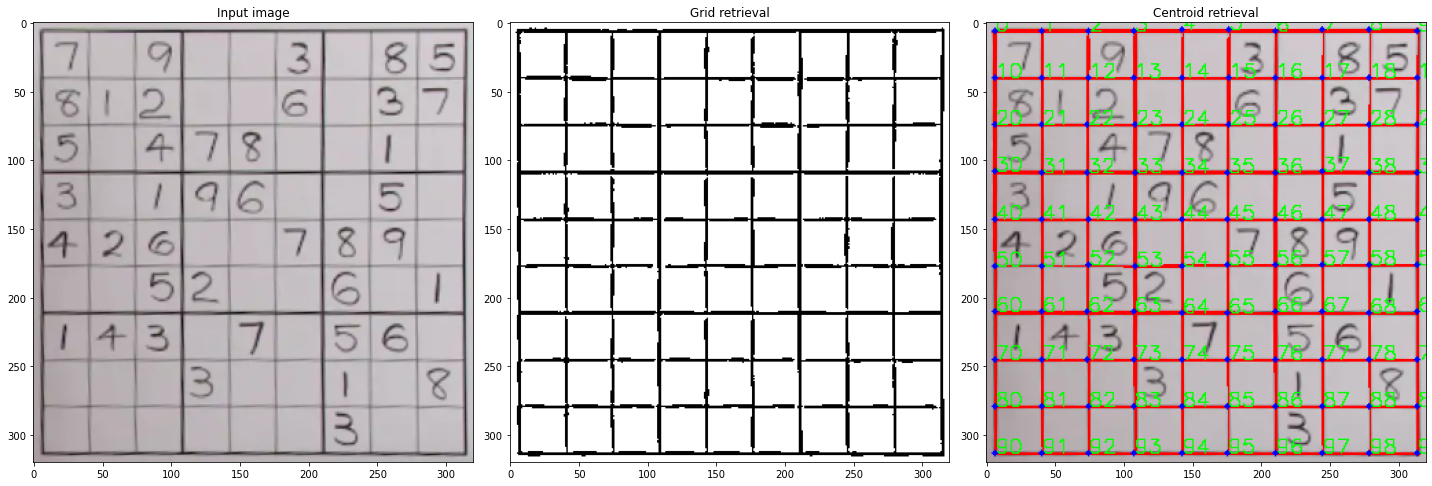

In [9]:
centroid, (grid, vis), bbox = get_res(warp_box)

fig = plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(warp_box)
plt.title('Input image')
plt.subplot(1,3,2)
plt.imshow(grid)
plt.title('Grid retrieval')
plt.subplot(1,3,3)
plt.imshow(vis)
plt.title('Centroid retrieval')


plt.tight_layout()
plt.show()

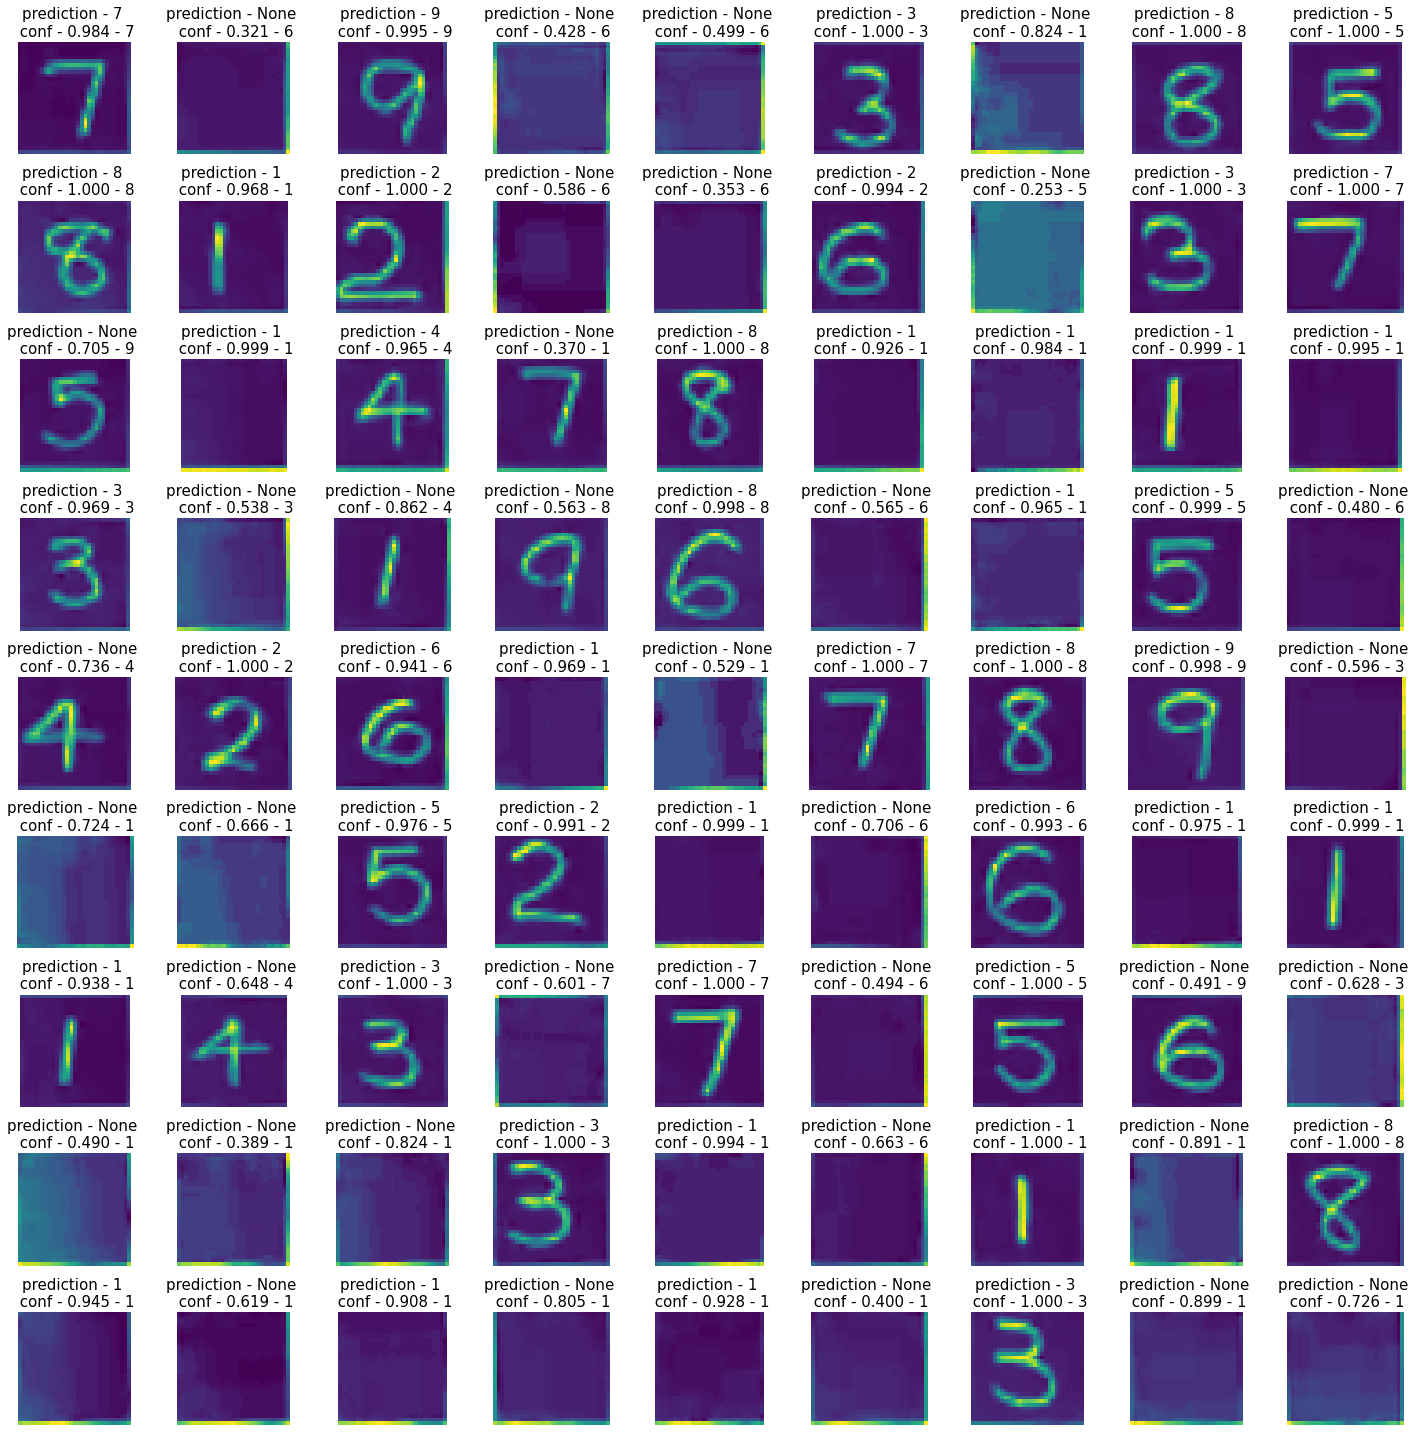

In [15]:
plt.figure(figsize=(20,20))
gray = cv2.cvtColor(warp_box, cv2.COLOR_RGB2GRAY)
for idx, (x0, x1, y0, y1) in enumerate(bbox):
    offset = 0
    inv = np.int0(np.invert(gray[y0+offset:y1-offset,x0+offset:x1-offset])).astype(np.uint8)
    inv = cv2.normalize(inv,  np.zeros(inv.shape), 0, 255, cv2.NORM_MINMAX)
    mean = np.mean(inv)
    img_resize = cv2.resize(inv, (28,28), interpolation=cv2.INTER_LINEAR)
    pred, confidence = inference_digit(digit, img_resize)
    l = pred if confidence > 0.9 else None

    plt.subplot(9,9,idx+1)
    plt.imshow(inv)
    plt.axis('off')
    plt.title(f'prediction - {l} \n conf - {confidence:.3f} - {pred}',fontsize=15)

plt.tight_layout()